# Introduction
**Starry Inc.** is a internet service provider that promises to deliver a wireless internet service that are faster and cheaper than traditional providers.

The first major product from Starry is Starry Station, a Wi-Fi router with a touchscreen that has many user-friendly features including;

- Monitors for internet connection and speed <br>
- Set up Wi-Fi directly from the device <br>
- Recognize and fix any problems that arise <br>
- Discover what speed they’re actually getting <br>
- Parental controls <br>
- Find their username and password with one click <br>
- Request a call from Starry Support <br>
- and more… <br>

In [1]:
from lxml import html 
import nltk, requests, string, re, collections
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

## Objective
Analyze Amazon reviews about Starry Station and identify potential improvements.

### Data Source
256 reviews on Amazon since 2016

https://www.amazon.com/Starry-Station-Touchscreen-Parental-Controls/product-reviews/B019GRZSAO/ref=cm_cr_arp_d_viewopt_kywd?ie=UTF8&reviewerType=all_reviews



## Data Collection (Web Scraping)
I used `lxml` library to collect Amazon reviews

In [2]:
Starry_url = 'https://www.amazon.com/Starry-Station-Touchscreen-Parental-Controls/product-reviews\
/B019GRZSAO/ref=cm_cr_arp_d_paging_btm_2?ie=UTF8&reviewerType=all_reviews&pageNumber={}&sortBy=recent'

user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'
headers = {'User-Agent': user_agent}

In [3]:
xpath_rating  = './/i[@data-hook="review-star-rating"]//text()' 
xpath_title   = './/a[@data-hook="review-title"]//text()'
xpath_author  = './/a[@data-hook="review-author"]//text()'
xpath_date    = './/span[@data-hook="review-date"]//text()'
xpath_body    = './/span[@data-hook="review-body"]//text()'
xpath_helpful = './/span[@data-hook="helpful-vote-statement"]//text()'
xpath_notHelpful = './/span[@data-hook="review-voting-widget"]//text()'
xpath_reviews = '//div[@data-hook="review"]'  

In [4]:
reviewDf = pd.DataFrame()
pageLength = 26
for pageNumber in range(1, pageLength+1):
    url = Starry_url.format(pageNumber)
    page = requests.get(url, headers = headers)
    parser = html.fromstring(page.content)
    reviews = parser.xpath(xpath_reviews)
    
    for review in reviews:
        rating  = review.xpath(xpath_rating)
        title   = review.xpath(xpath_title)
        author  = review.xpath(xpath_author)
        date    = review.xpath(xpath_date)
        body    = review.xpath(xpath_body)
        helpful = review.xpath(xpath_helpful)
        
        review_dict = {'rating': rating,
                       'title': title,
                       'author': author,             
                       'date': date,
                       'body': body,
                       'helpful': helpful}
        reviewDf = reviewDf.append(review_dict, ignore_index = True)

There are 256 reviews about Starry Station on Amazon

In [5]:
reviewDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 6 columns):
author     256 non-null object
body       256 non-null object
date       256 non-null object
helpful    256 non-null object
rating     256 non-null object
title      256 non-null object
dtypes: object(6)
memory usage: 12.1+ KB


In [6]:
reviewDf.head()

,author,body,date,helpful,rating,title
0,[Brian O'Conner],[About 20 or so devices connected to my home n...,"[on June 7, 2018]",[],[5.0 out of 5 stars],[I've been using it for a good while as I was ...
1,[Jim Stockham],[I really wanted to like the Starry Station. ...,"[on September 4, 2017]",[One person found this helpful],[2.0 out of 5 stars],[I'd have to say it's been disappointing]
2,[Alexander Kassab],"[It's pretty nice, not sure why so many compla...","[on August 7, 2017]",[],[5.0 out of 5 stars],"[It's pretty nice, not sure why so many compla..."
3,[Kevin L.],[I read a lot of mixed reviews on this bad boy...,"[on July 16, 2017]",[One person found this helpful],[5.0 out of 5 stars],"[So far, it's been great!]"
4,[Matt Nelson],[This is one of the most disappointing product...,"[on April 20, 2017]",[One person found this helpful],[2.0 out of 5 stars],[It's Like a Toaster that Doesn't Get Hot]


## Data Cleaning
All values are stored as `list`. Hence, I will extract values from the `list`s.

- `Date` : string --> datetime
- `rating` : extract ratings from strings (exclude all unnecessary information)
- `helpful` : extract helful scores from strings (empty lists are assigned zeros)
- `body`, `title` : extract strings from the list and combined two to create `Text` column

In [7]:
reviewDf.loc[:,'date'] = reviewDf.loc[:,'date'].apply(lambda x : '-'.join(x[0].replace(',','').split()[1:]))
reviewDf.loc[:,'date'] = reviewDf.loc[:,'date'].apply(lambda x : datetime.strptime(x, '%B-%d-%Y'))

In [8]:
reviewDf.loc[:,'rating'] = reviewDf.loc[:,'rating'].apply(lambda x : int(x[0].split('.')[0]))

In [9]:
reviewDf.loc[:,'helpful'] = reviewDf.loc[:,'helpful'].apply(lambda x : x[0].split()[0] if x else 0)
reviewDf.loc[:,'helpful'] = reviewDf.loc[:,'helpful'].replace('One', 1)
reviewDf.loc[:,'helpful'] = reviewDf.loc[:,'helpful'].apply(lambda x : int(x))

In [10]:
reviewDf.loc[:,'body'] = reviewDf.loc[:,'body'].apply(lambda x : x[0].lower())
reviewDf.loc[:,'title'] = reviewDf.loc[:,'title'].apply(lambda x : x[0].lower())
reviewDf['Text'] = reviewDf.loc[:,'title'] + reviewDf.loc[:,'body']

In [11]:
reviewDf.head()

,author,body,date,helpful,rating,title,Text
0,[Brian O'Conner],about 20 or so devices connected to my home ne...,2018-06-07,0,5,i've been using it for a good while as i was a...,i've been using it for a good while as i was a...
1,[Jim Stockham],i really wanted to like the starry station. i...,2017-09-04,1,2,i'd have to say it's been disappointing,i'd have to say it's been disappointingi reall...
2,[Alexander Kassab],"it's pretty nice, not sure why so many complai...",2017-08-07,0,5,"it's pretty nice, not sure why so many complaints","it's pretty nice, not sure why so many complai..."
3,[Kevin L.],i read a lot of mixed reviews on this bad boy ...,2017-07-16,1,5,"so far, it's been great!","so far, it's been great!i read a lot of mixed ..."
4,[Matt Nelson],this is one of the most disappointing products...,2017-04-20,1,2,it's like a toaster that doesn't get hot,it's like a toaster that doesn't get hotthis i...


## Data Visualization
- Rating Distribution
- Helpful Score Distribution
- Popular Words/Phrases

### Rating Distribution

**Rating Distribution** 
- 5-Star : 61% | 4-Star : 11% | 3-Star : 7% | 2-Star : 8% | 1-Star : 13%

**Time-Series Rating (2016–2018)**
- Reviews were actively posted after April 2016 since Starry Station was available on Amazon in early February and started shipping in March.
- Most of the reviews were posted in 2016.
- Approximately 10% of total reviews were posted in 2017
- There is only 1 new review posted in 2018 → new potential purchases are affected by old reviews
- Generally, there were more positive reviews than neutral and negative review (Good!)

In [12]:
reviewDf.reset_index(drop=True, inplace=True)
ratingOvertime = reviewDf.groupby(['date','rating']).count()['author'].unstack().fillna(0)

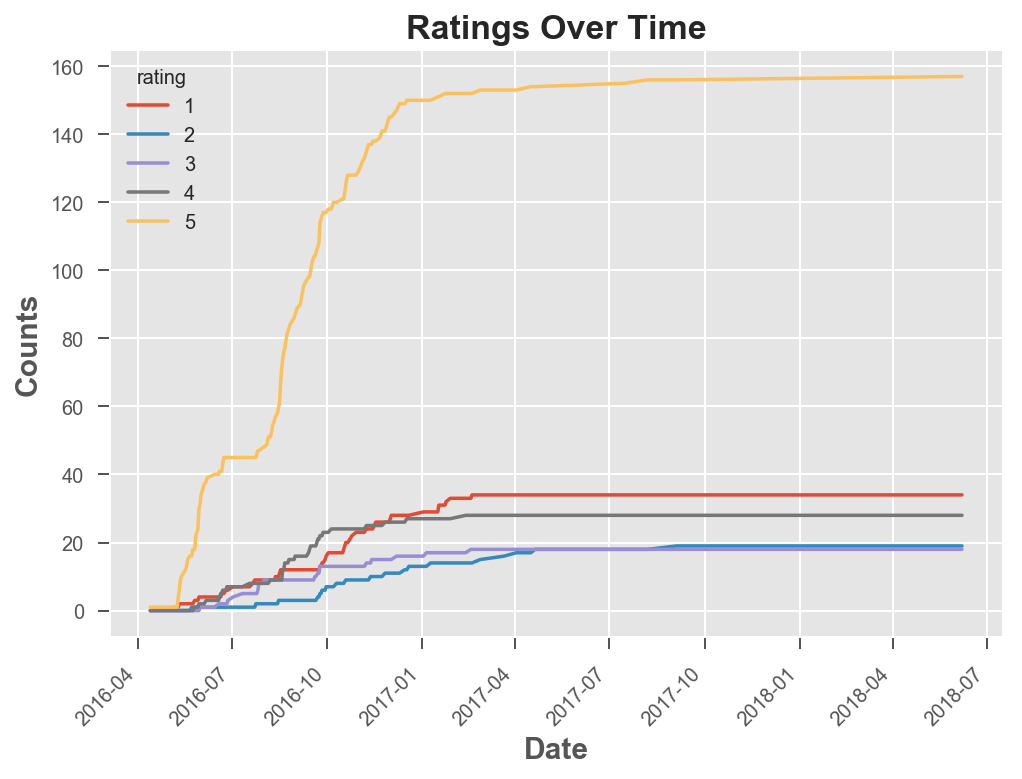

In [13]:
ratingOvertime.cumsum().plot(figsize=(8,6), rot = 45)
plt.style.use('bmh')
plt.title('Ratings Over Time', fontweight="bold", fontsize = 17)
plt.xlabel('Date',fontweight = "bold", fontsize = 15)
plt.ylabel('Counts',fontweight = "bold", fontsize = 15)
sns.set()
plt.show()

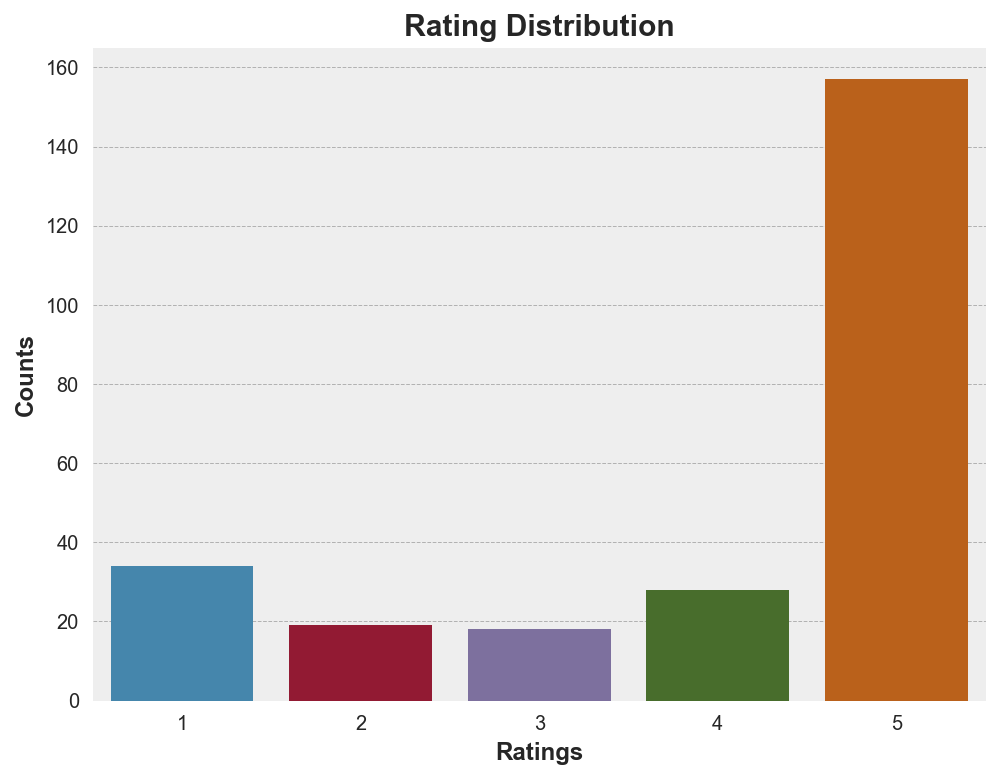

In [14]:
ratingDist = reviewDf.groupby('rating').count()['author']
plt.style.use('bmh')
plt.figure(1, figsize=(8, 6))
sns.barplot([1,2,3,4,5], ratingDist)
plt.title('Rating Distribution', fontweight="bold", fontsize = 15)
plt.xlabel('Ratings', fontweight="bold", fontsize = 12)
plt.ylabel('Counts', fontweight="bold", fontsize = 12)
plt.show()

### Helpful Score Distribution

**Helpful Reviews**
In Amazon review, there is a feature called Top Positive and Critical Reviews. Top Positive Reviews indicates reviews positive reviews with high ‘helpful’ scores and Top Critical Reviews indicates reviews negative reviews with high ‘helpful’ scores.

Those Top reviews might influence decisions customers make. I defined ‘Important Reviews’ as reviews that received at least 10 ‘helpful’ scores

Let’s look at the overall distributions of helpful scores and Important Reviews.

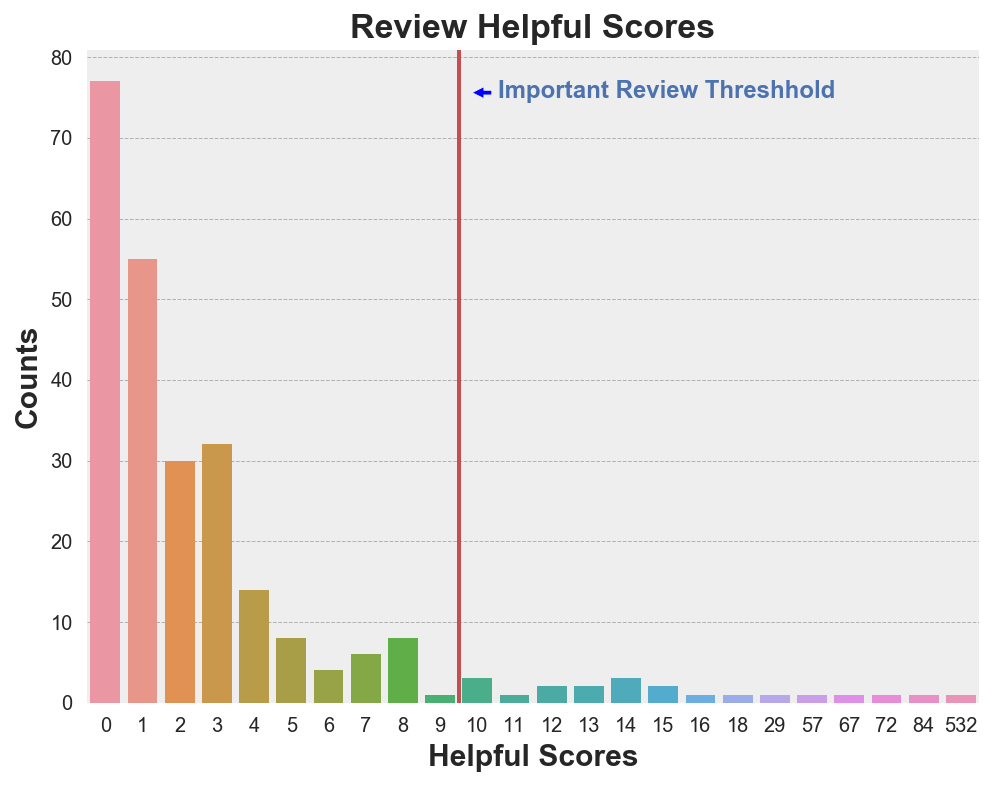

In [15]:
reviewHelpful = reviewDf.groupby('helpful').count()['author']
plt.figure(figsize=(8, 6))
sns.barplot(reviewHelpful.index,reviewHelpful)
plt.title('Review Helpful Scores', fontsize = 17, fontweight="bold")
plt.xlabel('Helpful Scores', fontsize = 15, fontweight="bold")
plt.ylabel('Counts', fontsize = 15, fontweight="bold")
plt.axvline(x = 9.5, color = 'r')
plt.text(x = 10.55, y = 75, s = 'Important Review Threshhold', fontsize = 12, fontweight="bold", color = 'b')
plt.annotate("", xy=(9.75, 75.6), xytext=(10.5, 75.6), arrowprops=dict(arrowstyle='simple'))
plt.show()

In [16]:
reviewImportant = reviewDf[(reviewDf['helpful'] >= 10)]
reviewImportant.groupby('rating').mean()

,helpful
rating,
1,22.833333
2,11.000000
3,42.000000
5,72.272727


- Avg. Helpful Scores : 1-Star : 23 | 2-Star : 11 | 3-Star : 42 | 5-Star : 72

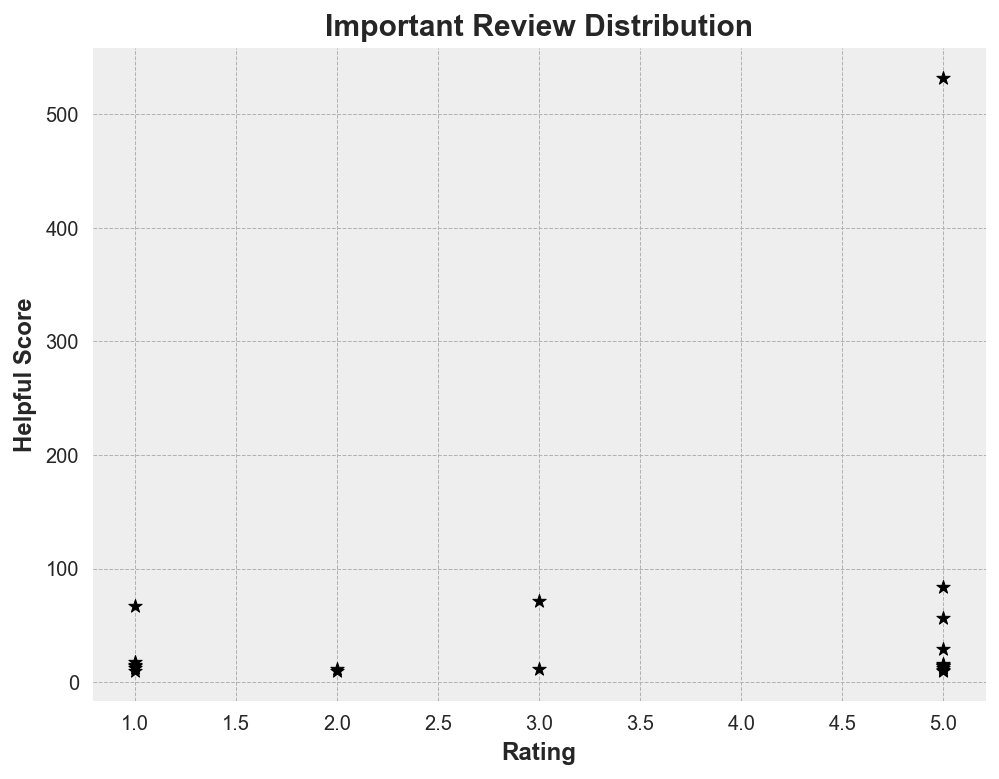

In [17]:
fig = plt.figure(figsize = (8,6))
plt.style.use('bmh')
plt.scatter(reviewImportant['rating'], reviewImportant['helpful'], marker = "*", color = 'black')
plt.title('Important Review Distribution', fontweight = 'bold', fontsize = 15)
plt.xlabel('Rating', fontweight = 'bold', fontsize = 12)
plt.ylabel('Helpful Score', fontweight = 'bold', fontsize = 12)
plt.show()

- Overall, there are more positive and neutral reviews in Important Reviews, than negative reviews.
- There is one positive review with 532 helpful scores. It was a very thorough and somewhat sounded like a professional review. Since a lot of people upvoted this review, it may be worth going over.


In [18]:
# Most Popular Positive Review
reviewDf.iloc[242,:]

author                                      [ubersimple.com]
body                                       update at bottom:
date                                     2016-05-17 00:00:00
helpful                                                  532
rating                                                     5
title      starry wifi access point is out of this world ...
Text       starry wifi access point is out of this world ...
Name: 242, dtype: object

In [19]:
# Most Popular Negative Review
reviewDf.iloc[192,:]

author                                           [Oppenheim]
body       starry station is completely over-hyped.  it h...
date                                     2016-07-02 00:00:00
helpful                                                   67
rating                                                     1
title       below average product at an above average price.
Text       below average product at an above average pric...
Name: 192, dtype: object

### Popular Words/Phrases

Below are word clouds using the post popular words in positive (4–5 stars) and negative (1–2 stars) reviews.

In positive reviews, there are words like “easy”, “unique”, “cool”, “love”, “absolutely”, “awesome”, “simple”, “good”, “nice”, “awesome” and etc.

In negative reviews, there are words like “disappointed”, “average”, “slow”, “value”, “returned”, “toaster”, “outage”, and etc.

In [20]:
nltk_words = set(stopwords.words('english'))
Allstopwords = set(STOPWORDS)
exclude = set(string.punctuation)
starry = set(["starry", "Starry", 'Station', 'station', 'router'])

Allstopwords = STOPWORDS | exclude | starry | nltk_words
def wordcloud_word(data,title=None):
    wordcloud=WordCloud(
               background_color='white',
               stopwords=Allstopwords,
               max_words=200,
               max_font_size=40).generate(str(data))  
    fig = plt.figure(1, figsize=(15, 6))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [21]:
positiveReviews = reviewDf[reviewDf.loc[:,'rating'] > 3]['Text']
neutralReviews = reviewDf[reviewDf.loc[:,'rating'] == 3]['Text']
negativeReviews = reviewDf[reviewDf.loc[:,'rating'] < 3]['Text']

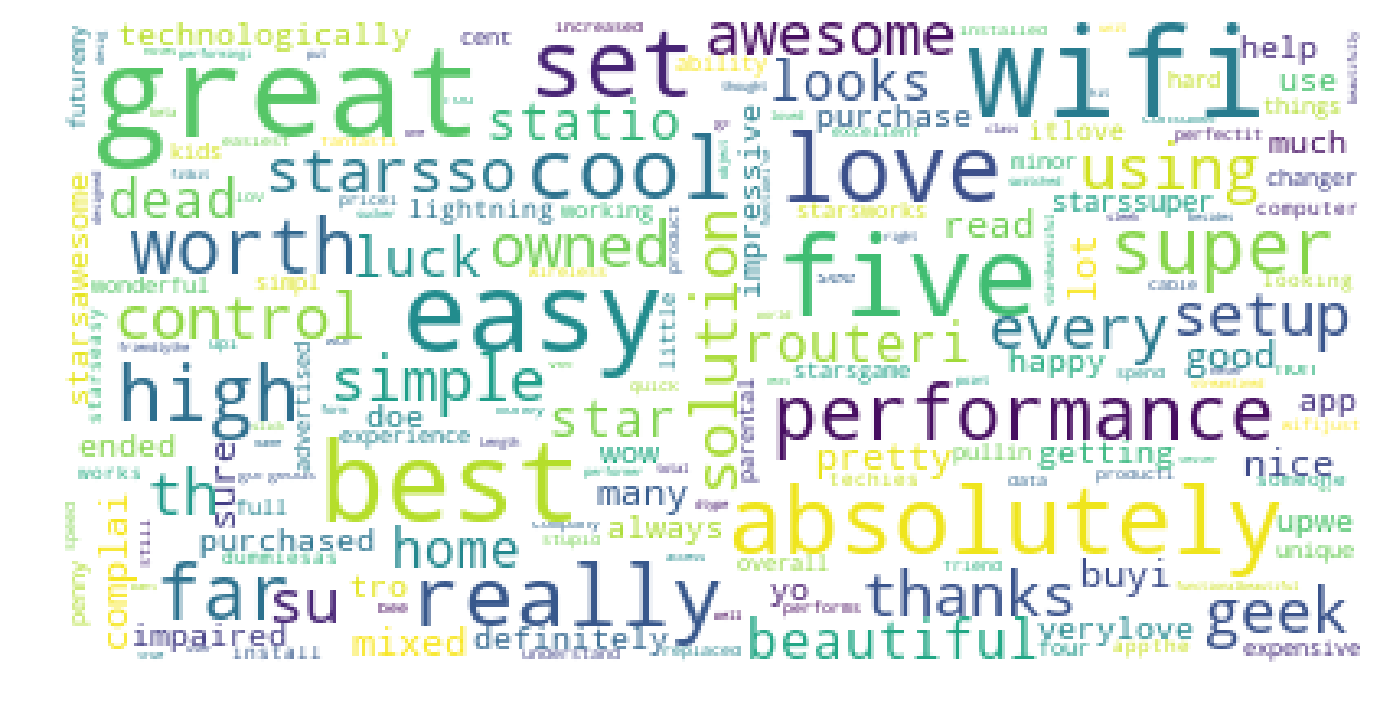

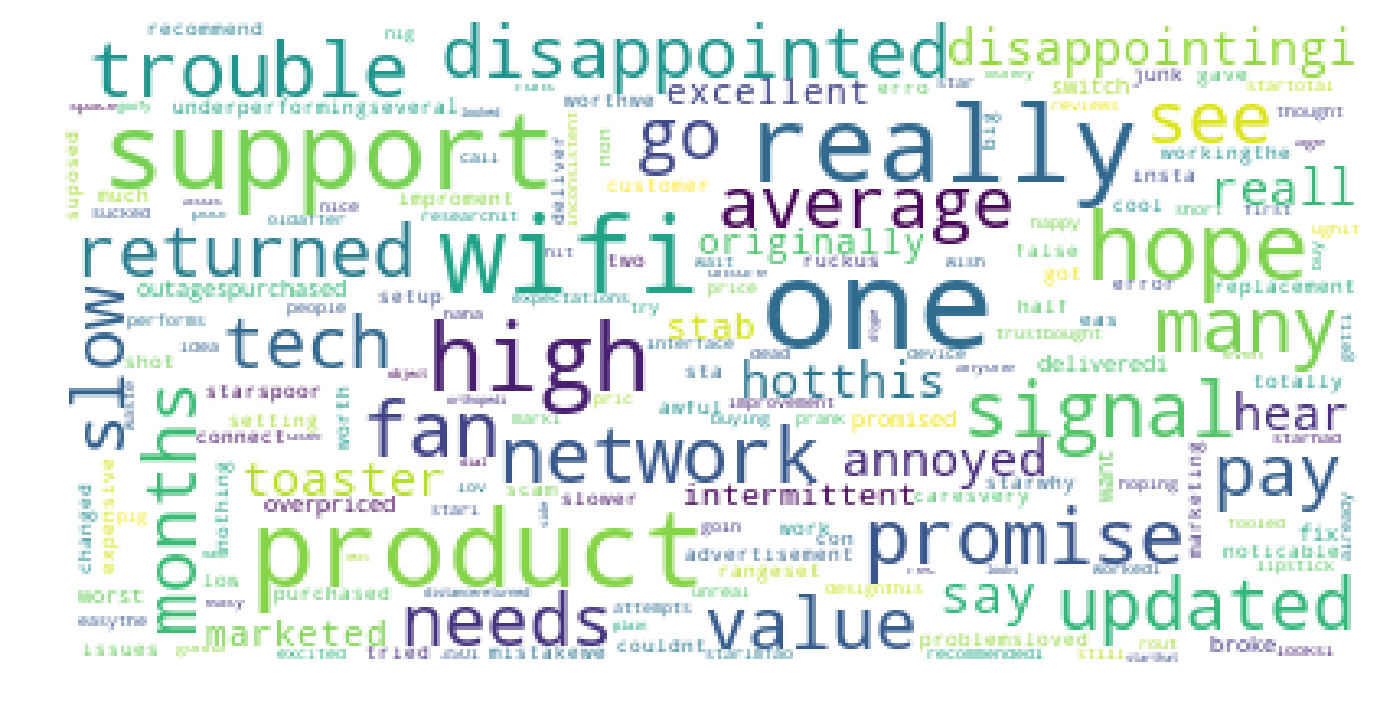

In [22]:
wordcloud_word(positiveReviews)
#wordcloud_word(neutralReviews)
wordcloud_word(negativeReviews)

However, it is really hard to tell what customers like/hate about Starry Station. So, I tried to capture phrases that were frequently used in the reviews. (2-grams and 3-grams worked best for positive and negative reviews respectively)

In [23]:
def wordcloud_phrase(text, ngram):
    plt.style.use('seaborn-white')
    fig = plt.figure()
    fig.set_size_inches(15, 6)

    num_words = 200
    ngram_range = (ngram, ngram)

    count_vectorizer = CountVectorizer(lowercase = True,
                                       stop_words = Allstopwords,
                                       ngram_range = ngram_range)

    counts = count_vectorizer.fit_transform(text)
    counts = counts.toarray().sum(axis=0)

    count_weighting = dict(zip(count_vectorizer.get_feature_names(), counts))
    
    count_weighting_df = pd.DataFrame.from_dict(count_weighting, orient='index')
    count_weighting_df = count_weighting_df.reset_index(drop=False)
    count_weighting_df.columns = ['word', 'count']
    count_weighting_df = count_weighting_df.sort_values(['count'], ascending=False)
    count_weighting_df = count_weighting_df.set_index('word')

    word_cloud_freq = count_weighting_df['count'].head(num_words).to_dict()
    wordcloud = WordCloud(collocations=False).generate_from_frequencies(word_cloud_freq)
    plt.imshow(wordcloud, cmap=plt.cm.bone, interpolation='bilinear')
    plt.axis("off")
    plt.show()

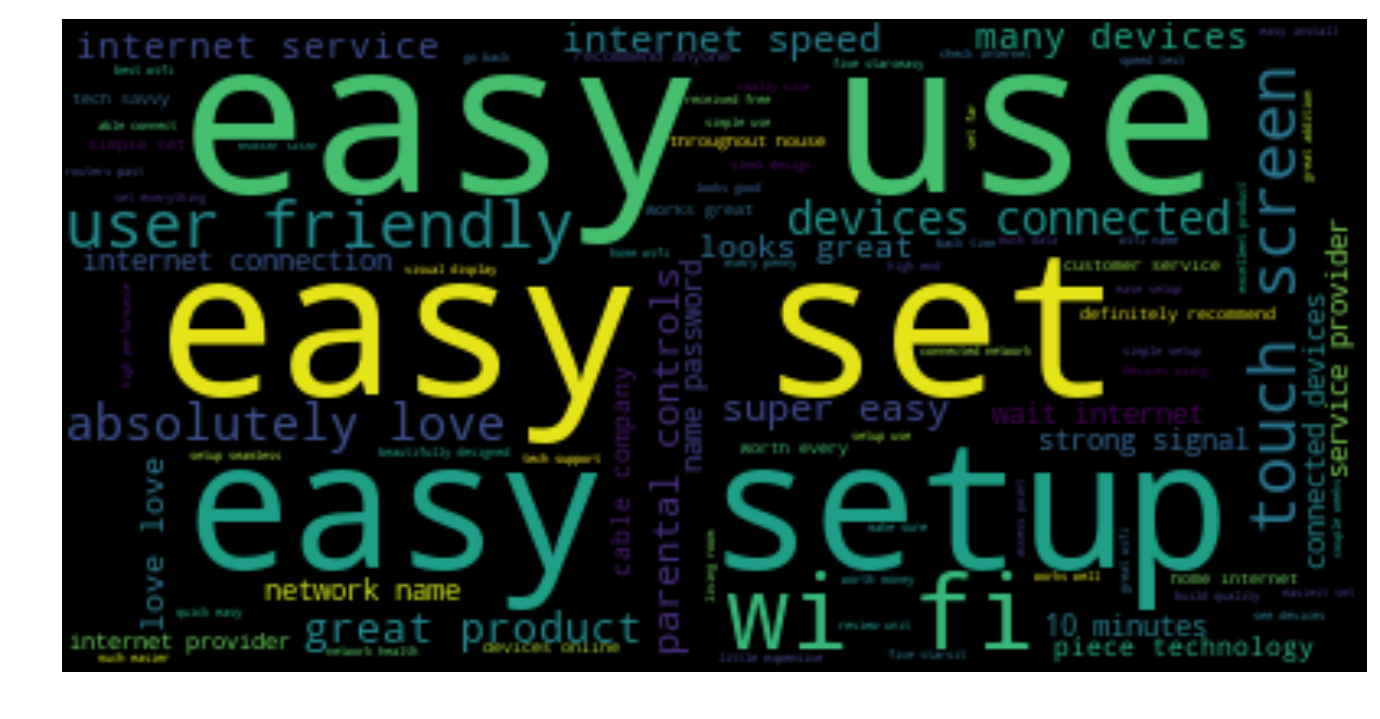

In [24]:
wordcloud_phrase(positiveReviews, 2)

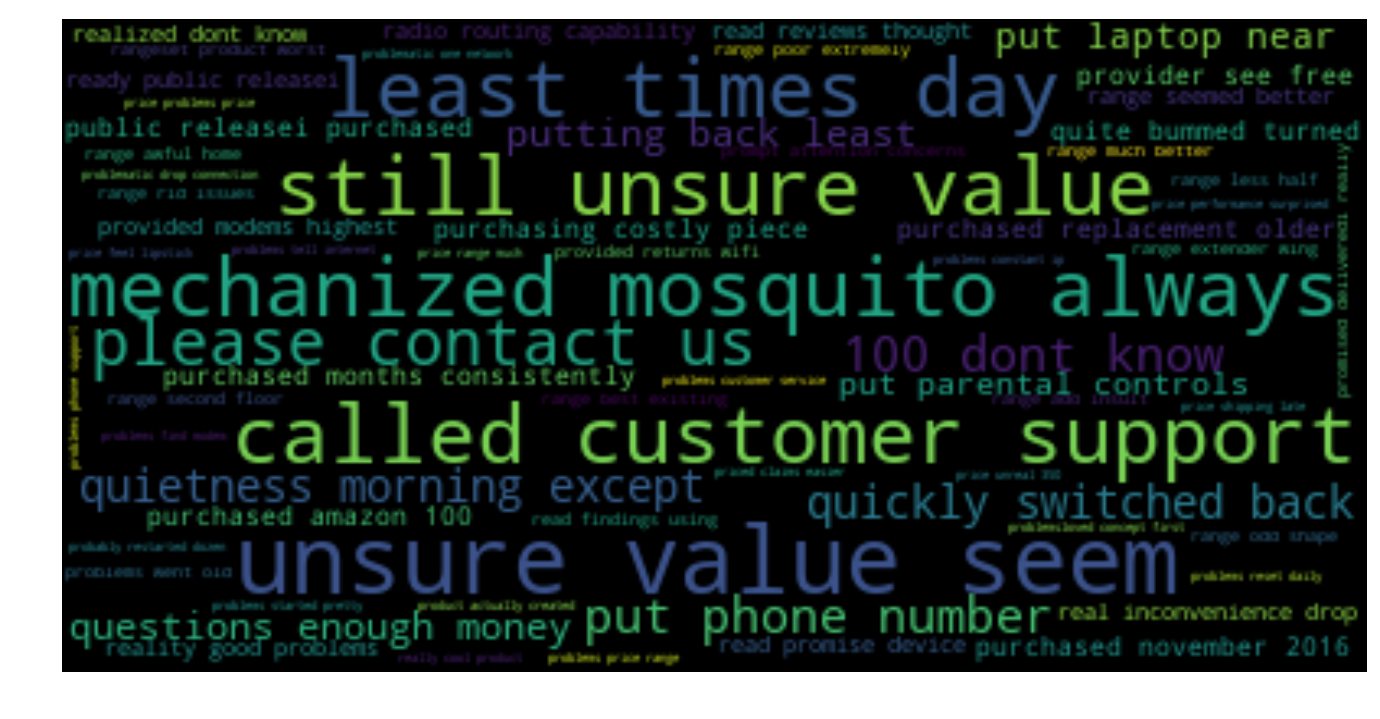

In [25]:
wordcloud_phrase(negativeReviews, 3)

Now, we can see what customers liked or didn’t liked about Starry Station.

From the positive reviews, it is clear that customers really appreciate the product’s user friendliness. Phrases like “easy set”, “easy setup”, “easy use”, “touch screen”, and “user friendly” were particularly highlighted.

On the other hand, phrases like “still unsure value”, and “unsure value seem” indicate customers think the product is overpriced. Also, phases like “put near laptop”, “mechanized mosquito always”, and “quietness morning except” indicate that customers experienced some kind of product malfunction (loud fan, wifi range etc).

### Discussion
According to BrightLocal survey(2017), 85 percent of consumers trust online reviews as much as personal recommendations. Moreover, consumers trust Amazon as Amazon actively defends integrity of its reviews. I think it is worthwhile analyzing the production review to make improvements in product and services.

>“Customers trust that they can shop with confidence on Amazon. Reviews provide … authentic feedback about products and services. Any attempt to manipulate reviews … is strictly prohibited.”

From this brief sentiment analysis about Starry Station, it was clear that customers were generally satisfied with the product and experience. User friendly interface and installation were highly appreciated in particular. However, there are still room for improvements. Customers were unsure about the price and some had bad experience using the product. Fan noise and wifi range were two issues highlighted.

For further analysis, it would give better idea of where Starry Station stands in the market and help make strategic decision by analyzing customer reviews in router subcategory.

- “Does Starry Station provide intended/unintended experience?”
- “What features Starry Station better/lack compare to competitors?”
- “Do we have appropriate pricing strategy?”
- and more…

I support the values Starry Inc. is planning to provide to the world. Hope it expands service areas soon.